<h1 style="text-align:center;">Demo for PathRWKV</h1>

<div align="center">

![Python](https://img.shields.io/badge/Python-3.12.12-3776AB?style=for-the-badge&logo=python&logoColor=white)
![PyTorch](https://img.shields.io/badge/PyTorch-2.9.1-EE4C2C?style=for-the-badge&logo=pytorch&logoColor=white)
![CUDA](https://img.shields.io/badge/CUDA-12.8-76B900?style=for-the-badge&logo=nvidia&logoColor=white)

</div>

---
## 📚 Summary

This notebook demonstrated the complete PathRWKV pipeline:

| Step | Description | Output |
|------|-------------|--------|
| 1️⃣ Preprocessing | WSI → Tiles | `.jpeg` images + `dataset.csv` |
| 2️⃣ Embedding | Tiles → Features | `.safetensors` files |
| 3️⃣ Training | Features → Model | Checkpoints + TensorBoard logs |
| 4️⃣ Testing | Model → Metrics | `results.json` |

## ☁️ Google Colab Setup

Run this cell only if you are using Google Colab.

In [1]:
# Check if running in Colab
import os
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🌐 Running in Google Colab!")

    # Clone the repository
    %cd /content
    !git clone https://github.com/Puzzle-Logic/PathRWKV.git
    %cd PathRWKV

    # Install system dependencies
    !apt-get update && apt-get install -y openslide-tools

    # Install Python dependencies
    !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128
    !pip install pytorch-lightning torchmetrics timm monai polars pyyaml safetensors
    !pip install scikit-survival openslide-python pillow tqdm scipy tensorboard matplotlib awscli
    print("✅ Colab setup complete!")
else:
    print("💻 Running locally")

💻 Running locally


## 📦 Import Libraries

In [2]:
import sys
import torch
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Set the project root
if IN_COLAB:
    PROJECT_ROOT = Path('/content/PathRWKV')
else:
    PROJECT_ROOT = Path('.').resolve()

sys.path.insert(0, str(PROJECT_ROOT))

# Print system info
print(f"🐍 Python: {sys.version}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🖥️ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print(f"📁 Project Root: {PROJECT_ROOT}")

🐍 Python: 3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:25:55) [GCC 14.3.0]
🔥 PyTorch: 2.9.1+cu128
🖥️ CUDA Available: True
🎮 GPU: NVIDIA H200 NVL
📁 Project Root: /data/sicheng


---
## 🗂️ Step 1: WSI Preparation

This step downloads a test sample (test_001.tif) from CAMELYON16 dataset on AWS3, and converts it into small tiles for feature embedding.

### Key Parameters:
- `tile_size`: Size of each tile (default: 224×224 pixels)
- `target_mpp`: Microns per pixel (default: 0.5 for 20x magnification)
- `t_occupancy`: Minimum tissue occupancy threshold (default: 0.1)

In [ ]:
# Download data
from pathlib import Path

wsi_dir = Path("/content/PathRWKV/CAMELYON16/images")
wsi_dir.mkdir(exist_ok=True)
target_file = wsi_dir / "test_001.tif"

if not target_file.exists():
    print(f"⬇️ Downloading {target_file.name} from AWS Open Data (CAMELYON16)...")
    !aws s3 cp s3://camelyon-dataset/CAMELYON16/images/test_001.tif {wsi_dir} --no-sign-request
    print(f"✅ Download complete! File download to {wsi_dir}")
else:
    print(f"✅ {target_file.name} already exists.")

✅ test_001.tif already exists.


In [7]:
# Run preprocessing
# This will take 2-3 minutes
from PathRWKV.UpStream.preprocess import process_all_slides

process_all_slides(
    input_dir="/data/sicheng/WSI/CAMELYON16/images",
    output_dir="/data/sicheng/WSI/CAMELYON16/tiles",
    gen_thumbnails=True,
)

print("✅ Preprocessing step ready")

/home/sicheng/miniforge3/envs/UnPuzzle/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 1 slides.


Slides: 100%|██████████| 1/1 [01:35<00:00, 95.34s/WSI]


✅ Preprocessing step ready


### 📊 Visualize Tiling Results

✅ Found 10 ROI tiles.


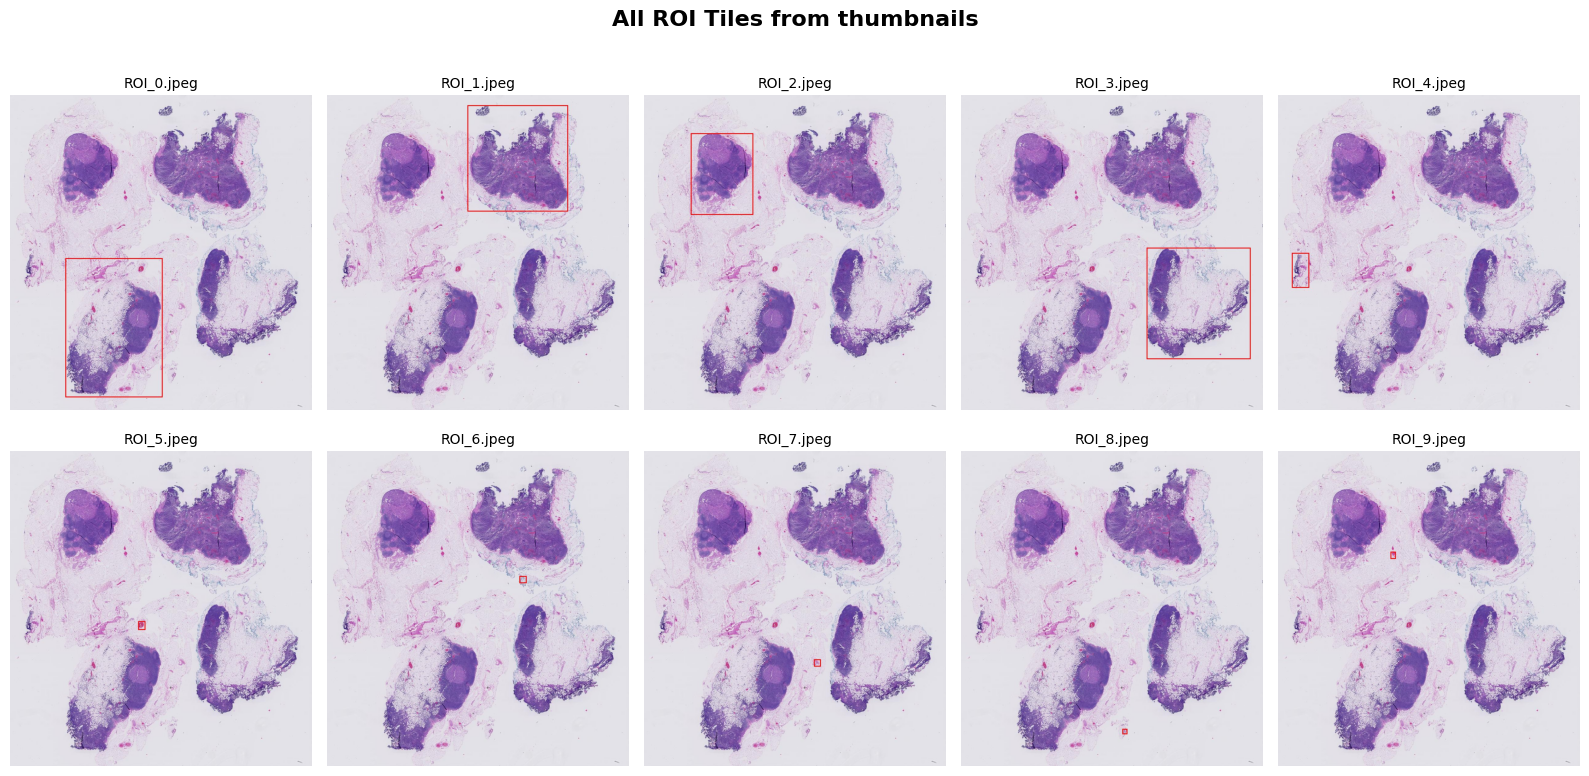

In [ ]:
# Visualize generated thumbnails
from pathlib import Path
import math

slide_dir = Path("/content/PathRWKV/CAMELYON16/tiles/thumbnails")
tile_files = sorted(list(slide_dir.glob('*ROI*.jpeg')))
print(f"✅ Found {len(tile_files)} ROI tiles.")

n_cols = 5
n_rows = math.ceil(len(tile_files) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < len(tile_files):
        tile_path = tile_files[idx]
        img = Image.open(tile_path)
        ax.imshow(img)
        filename = tile_path.name
        short_title = filename.split("original_")[-1]
        ax.set_title(short_title, fontsize=10)

    ax.axis('off')

plt.suptitle(f'All ROI Tiles from {slide_dir.name}', fontsize=16, fontweight='bold', y=1.005)
plt.tight_layout()
plt.show()

---
## 🧠 Step 2: Feature Embedding

Extract features from tiles using **Prov-GigaPath**.

In [ ]:
# Configuration for embedding
# ⚠️️ This requires access to the model
# You can skip this step and directly download
# the embedded features in the next step
os.environ['HF_TOKEN'] = "YOUR_HF_TOKEN_HERE"
!python PathRWKV/UpStream/embed.py \
  --input_dir "/data/sicheng/WSI/CAMELYON16/tiles" \
  --output_dir "/data/sicheng/WSI/CAMELYON16/tiles-embeddings" \
  --model_name "hf_hub:prov-gigapath/prov-gigapath"

Scanning slides...
Total: 1, Processed: 1, Pending: 0
All slides processed.


### 📊 Inspect Embedding Results

📁 File: test_001.safetensors
  • Number of tiles: 7622
  • Feature dimension: 1536
  • Coordinates shape: torch.Size([7622, 2])
  • Feature stats: mean=-0.0031, std=0.9072


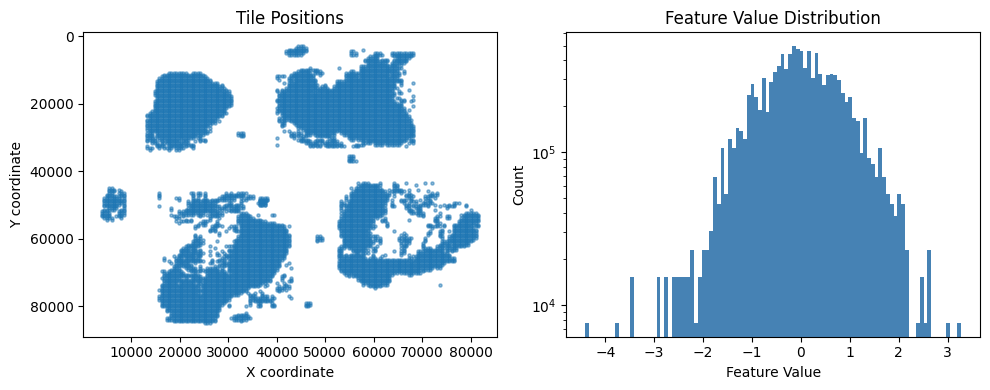

In [14]:
from safetensors.torch import safe_open

path = Path("/data/sicheng/WSI/CAMELYON16/tiles-embeddings/test_001.safetensors")
with safe_open(path, framework='pt', device='cpu') as f:
    features = f.get_tensor('features')
    coords = f.get_tensor('coords_yx')

print(f"📁 File: {path.name}")
print(f"  • Number of tiles: {features.shape[0]}")
print(f"  • Feature dimension: {features.shape[1]}")
print(f"  • Coordinates shape: {coords.shape}")
print(f"  • Feature stats: mean={features.mean():.4f}, std={features.std():.4f}")

# Visualize coordinate distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(coords[:, 1], coords[:, 0], alpha=0.5, s=5)
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')
axes[0].set_title('Tile Positions')
axes[0].invert_yaxis()

axes[1].hist(features.flatten().numpy(), bins=100, color="steelblue", edgecolor="none")
axes[1].set_xlabel("Feature Value")
axes[1].set_ylabel("Count")
axes[1].set_title("Feature Value Distribution")
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

---
## 🚀 Step 3: Training PathRWKV

Train PathRWKV for MIL.

In [ ]:
# Training Configuration
TRAIN_CONFIG = {
    # Environment
    'seed': 42,
    'devices': '0',  # GPU ID(s), e.g., '0', '0%1' for multi-GPU

    # Data
    'data_path': '/path/to/dataset',  # 📂 Root path containing embeddings
    'dataset_name': 'CAMELYON16',     # Dataset name (must match config folder)
    'max_tiles': 2000,                # Maximum tiles per slide during training
    'num_workers': 8,

    # Training
    'batch_size': 4,
    'epochs': 100,
    'lr': 1e-4,
    'lrf': 0.1,
    'early_stop_epoch': 10,

    # Paths
    'runs_path': str(PROJECT_ROOT / 'runs'),
}

print("🚀 Training Configuration:")
for key, value in TRAIN_CONFIG.items():
    print(f"  • {key}: {value}")

In [ ]:
# Prepare training arguments
class TrainArgs:
    def __init__(self, config):
        for key, value in config.items():
            setattr(self, key, value)
        self.mode = 'train'
        self.tasks = None  # Use all tasks from config
        self.resume_ckpt = None
        self.test_ckpt = None
        self.val_interval = 1.0
        self.disable_pbar = False

args = TrainArgs(TRAIN_CONFIG)

print("📋 Training arguments prepared")

In [ ]:
# Run training (uncomment to execute)
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from DownStream.utils.pipeline import WSIPipeline
from DownStream.utils.dataset import data_module
from DownStream.utils.utils import initialize_experiment

seed_everything(args.seed, workers=True)

# Initialize experiment
(
    args.data_path,
    args.input_dim,
    args.tasks,
    args.runs_path,
    args.runs_name,
    args.devices,
) = initialize_experiment(args)

# Setup logger and callbacks
tb_logger = TensorBoardLogger(
    version='tb',
    name=args.runs_name,
    default_hp_metric=False,
    save_dir=str(args.runs_path.parent),
)

checkpoint_callback = ModelCheckpoint(
    dirpath=args.runs_path / 'checkpoints',
    filename='best',
    monitor='Val/Loss',
    mode='min',
    save_top_k=1,
)

early_stop_callback = EarlyStopping(
    monitor='Val/Loss',
    min_delta=0.00001,
    patience=args.early_stop_epoch,
    verbose=True,
    mode='min',
)

# Create trainer
trainer = Trainer(
    logger=tb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=1,
    devices=args.devices,
    precision='bf16-mixed',
    max_epochs=args.epochs,
    num_sanity_val_steps=0,
    enable_model_summary=True,
    val_check_interval=args.val_interval,
    strategy='ddp' if len(args.devices) != 1 else 'auto',
)

# Train!
dm = data_module(args)
model = WSIPipeline(args)
trainer.fit(model, datamodule=dm)

print("✅ Training step completed")

### 📈 Monitor Training with TensorBoard

In [ ]:
# Load TensorBoard
%load_ext tensorboard

# Specify the logs directory
%tensorboard --logdir /path/to/runs

print("📈 TensorBoard ready (uncomment command to launch)")

---
## 📊 Step 4: Testing and Evaluation

Evaluate the trained model on the test set.

In [ ]:
# Testing Configuration
TEST_CONFIG = {
    **TRAIN_CONFIG,
    'test_ckpt': None,  # Path to checkpoint, None uses best.ckpt from runs_path
}

print("📊 Testing Configuration:")
for key in ['data_path', 'dataset_name', 'test_ckpt']:
    print(f"  • {key}: {TEST_CONFIG[key]}")

In [ ]:
# Run testing

test_args = TrainArgs(TEST_CONFIG)
test_args.mode = 'test'

seed_everything(test_args.seed, workers=True)

(
    test_args.data_path,
    test_args.input_dim,
    test_args.tasks,
    test_args.runs_path,
    test_args.runs_name,
    test_args.devices,
) = initialize_experiment(test_args)

# Setup trainer for testing
test_trainer = Trainer(
    logger=False,
    callbacks=None,
    devices=test_args.devices,
    precision='bf16-mixed',
)

# Load model and test
dm = data_module(test_args)
ckpt_path = (
    test_args.test_ckpt
    if test_args.test_ckpt
    else test_args.runs_path / 'checkpoints' / 'best.ckpt'
)
model = WSIPipeline.load_from_checkpoint(ckpt_path, args=test_args, weights_only=False)
test_trainer.test(model, datamodule=dm)

print("✅ Testing step completed")

### 📋 Load and Display Results

In [ ]:
import json

def display_results(results_path):
    """
    Display test results from a JSON file.

    Args:
        results_path: Path to results.json
    """
    path = Path(results_path)
    if not path.exists():
        print(f"❌ Results file not found: {path}")
        return

    with open(path, 'r') as f:
        results = json.load(f)

    print("\n" + "="*60)
    print("📊 TEST RESULTS")
    print("="*60 + "\n")

    for key, value in sorted(results.items()):
        if 'Test/' in key:
            metric_name = key.replace('Test/', '')
            print(f"  {metric_name}: {value:.4f}")

    print("\n" + "="*60)

display_results('/path/to/runs/dataset/model/experiment/results.json')
print("📋 Results display function ready")